In [2]:
#clear all
%reset -f

#import packages
import numpy as np
import sys
import os
import pandas as pd
import mne
import matplotlib
from sklearn.utils import resample
from mne_icalabel import label_components

root = 'F:/Documents/Science/MirRevAdaptEEG'
participants = list(range(0,32))
#specify which erp we are analyzing
erps = 'lrp'

#pop up plots as separate window & interactive
%matplotlib qt
matplotlib.pyplot.close('all')

In [3]:
#setting up path/ directory
#access specific file for specific participant
def load_epochs(pp_num, root_dir, erp_path, cond, task):

    root_directory = root_dir
    data_directory = os.path.join(root_directory, 'data/eeg/')
    id_directory = os.path.join(data_directory, 'p%03d/' % pp_num)
    pp_directory = os.path.join(id_directory, erp_path)
    filename = os.path.join(pp_directory, 'p%03d_%s_%s_rp-epo.fif' % (pp_num, cond, task))

    epochs = mne.read_epochs(filename)
    #baseline for each trial
    #if erp_path == 'frn':
        #epochs = epochs.apply_baseline(baseline = (-1.5, -1.2))
    #elif erp_path == 'lrp':
        #epochs = epochs.apply_baseline(baseline = (-1.3, -1.0))

    return epochs, pp_directory

In [ ]:
# #get index of trials from behavioral data
# def epoch_index(task, listval, pp, target = np.nan):
#     if task == 'rot':
#         df = pd.read_csv(r'F:\Documents\Science\MirRevAdaptEEG\data\ROT_learningcurve_degrees.csv')
#     elif task == 'rdm':
#         df = pd.read_csv(r'F:\Documents\Science\MirRevAdaptEEG\data\RDMROT_learningcurve_degrees_%02d.csv' % target)
#     elif task == 'aln':
#         df = pd.read_csv(r'F:\Documents\Science\MirRevAdaptEEG\data\ALIGNED_learningcurve_degrees.csv')
#     elif task == 'mir':
#         df = pd.read_csv(r'F:\Documents\Science\MirRevAdaptEEG\data\MIR_learningcurve_degrees_%02d.csv' % target)
   
#     ppdata = list(df.iloc[:,pp+1])
    
#     index = [i for i,v in enumerate(ppdata) if listval[0] < v < listval[1] or listval[2] < v < listval[3]]
    
#     #epochs_out = epochs[index]
#     numtrials = len(index)
    
#     #return epochs_out, numtrials
#     return index, numtrials

In [4]:
def direction_index(task, direction, pp):
    if task == 'aln':
        df = pd.read_csv(r'F:\Documents\Science\MirRevAdaptEEG\data\aln_MovementWorkspace_direction.csv')
    elif task == 'rdmrot':
        df = pd.read_csv(r'F:\Documents\Science\MirRevAdaptEEG\data\rdmrot_MovementWorkspace_direction.csv')
    elif task == 'rdmmir':
        df = pd.read_csv(r'F:\Documents\Science\MirRevAdaptEEG\data\rdmmir_MovementWorkspace_direction.csv')
    elif task == 'rot':
        df = pd.read_csv(r'F:\Documents\Science\MirRevAdaptEEG\data\rot_MovementWorkspace_direction.csv')
    elif task == 'mir':
        df = pd.read_csv(r'F:\Documents\Science\MirRevAdaptEEG\data\mir_MovementWorkspace_direction.csv')
    
    ppdata = list(df.iloc[:,pp+1])

    index = [i for i,v in enumerate(ppdata) if direction == v]

    numtrials = len(index)
    
    return index, numtrials

In [5]:
def trial_list_rdm(task, pp, index):
    df = pd.read_csv(r'F:\Documents\Science\MirRevAdaptEEG\data\eeg\p%03d\%s\mra_p%03d_tasktrigindex.csv' % (pp, erps, pp))
    
    #even pp numbers would experience rotation first (need random before this)
    #need to also take into account missing triggers from previous tasks
    if pp % 2 == 0:
        if task == 'rdmrot':
            #get trial after first task (trial 48 to 95, 234 to 281)
            tasksdf = df[0:96]
            subtasksdf = tasksdf.loc[tasksdf['tasktrig'] == 16150]
            triallist = []
            for i in index:
                ndat = subtasksdf.loc[subtasksdf['trialno'] == i]
                nint = int(ndat['trigidx'])
                if nint == 1:
                    trial = int(ndat['ctrial'])
                    triallist.append(trial)
                    
        elif task == 'rdmmir':
            #get trial after first task (trial 48 to 95)
            tasksdf = df[0:282]
            subtasksdf = tasksdf.loc[tasksdf['tasktrig'] == 16153]
            triallist = []
            for i in index:
                ndat = subtasksdf.loc[subtasksdf['trialno'] == i]
                nint = int(ndat['trigidx'])
                if nint == 1:
                    trial = int(ndat['ctrial'])
                    triallist.append(trial)
            
    elif pp % 2 == 1:   
        if task == 'rdmrot':
            #get trial after first five tasks (trial 234 to 281)
            tasksdf = df[0:282]
            subtasksdf = tasksdf.loc[tasksdf['tasktrig'] == 16153]
            triallist = []
            for i in index:
                ndat = subtasksdf.loc[subtasksdf['trialno'] == i]
                nint = int(ndat['trigidx'])
                if nint == 1:
                    trial = int(ndat['ctrial'])
                    triallist.append(trial)
            
        elif task == 'rdmmir':
            #get trial after first task (trial 48 to 95)
            tasksdf = df[0:96]
            subtasksdf = tasksdf.loc[tasksdf['tasktrig'] == 16150]
            triallist = []
            for i in index:
                ndat = subtasksdf.loc[subtasksdf['trialno'] == i]
                nint = int(ndat['trigidx'])
                if nint == 1:
                    trial = int(ndat['ctrial'])
                    triallist.append(trial)

    
    return(triallist)
    

In [6]:
#get matching trials from eeg data, where we account for missing triggers
def epoch_trials(task, pp, epochs, index):

    df = pd.read_csv(r'F:\Documents\Science\MirRevAdaptEEG\data\eeg\p%03d\%s\mra_p%03d_tasktrigindex.csv' % (pp, erps, pp))
    
    if task == 'aln':
        #get trial numbers where tasktrig is 16149 and trigidx is 1
        tasksdf = df[0:48]
        subtasksdf = tasksdf.loc[tasksdf['tasktrig'] == 16149]
        triallist = []
        for i in index:
            ndat = subtasksdf.loc[subtasksdf['trialno'] == i]
            nint = int(ndat['trigidx'])
            if nint == 1:
                trial = int(ndat['ctrial'])
                triallist.append(trial)

        epochs = epochs[triallist]
    
    #for the other tasks, the order depends on their pp number
    #even pp numbers would experience rotation first (need random before this)
    #need to also take into account missing triggers from previous tasks
    if pp % 2 == 0:
        if task == 'rot':
            #rot trials are after first two tasks (trial 96 to 185)
            tasksdf = df[0:186]
            subtasksdf = tasksdf.loc[tasksdf['tasktrig'] == 16151]
            triallist = []
            for i in index:
                ndat = subtasksdf.loc[subtasksdf['trialno'] == i]
                nint = int(ndat['trigidx'])
                if nint == 1:
                    trial = int(ndat['ctrial'])
                    triallist.append(trial)

            epochs = epochs[triallist]
      
        elif task == 'mir':
            #get trial after first task (trial 282 to 371)
            tasksdf = df[0:372]
            subtasksdf = tasksdf.loc[tasksdf['tasktrig'] == 16154]
            triallist = []
            for i in index:
                ndat = subtasksdf.loc[subtasksdf['trialno'] == i]
                nint = int(ndat['trigidx'])
                if nint == 1:
                    trial = int(ndat['ctrial'])
                    triallist.append(trial)

            epochs = epochs[triallist]
            
    elif pp % 2 == 1:
        if task == 'rot':
            #get trial after first five tasks (trial 282 to 371)
            tasksdf = df[0:372]
            subtasksdf = tasksdf.loc[tasksdf['tasktrig'] == 16151]
            triallist = []
            for i in index:
                ndat = subtasksdf.loc[subtasksdf['trialno'] == i]
                nint = int(ndat['trigidx'])
                if nint == 1:
                    trial = int(ndat['ctrial'])
                    triallist.append(trial)

            epochs = epochs[triallist]

        elif task == 'mir':
            #get trial after first five tasks (trial 96 to 185)
            tasksdf = df[0:186]
            subtasksdf = tasksdf.loc[tasksdf['tasktrig'] == 16154]
            triallist = []
            for i in index:
                ndat = subtasksdf.loc[subtasksdf['trialno'] == i]
                nint = int(ndat['trigidx'])
                if nint == 1:
                    trial = int(ndat['ctrial'])
                    triallist.append(trial)

            epochs = epochs[triallist]
    
    return(epochs)

In [ ]:
#save epochs
def output_condition_epochs(pp_num, data, ppdir, condname, task):
    # Save the cleaned data :)
    out_fname = os.path.join(ppdir, 'p%03d_%s_%s_rp-epo.fif' % (pp_num, condname, task))
    data.save(out_fname, overwrite = True)

In [ ]:
#save as an evoked object
def output_condition_evoked(pp_num, data, ppdir, condname, task):
    evoked = data.average()
    out_fname = os.path.join(ppdir, 'p%03d_%s_%s_rp-ave.fif' % (pp_num, condname, task))
    evoked.save(out_fname, overwrite = True)

In [7]:
#save as evoked objects
conditions = ['r', 'l']
conditionnames = ['rightmoves', 'leftmoves']
l_cutoff = 30

#no cutoffs needed, we want all trials regardless of error size, just whether they reached right or left
tasks = ['aln', 'rot', 'mir']


for task in range(0, len(tasks)):
    for pp in participants:
        data, ppdir = load_epochs(pp, root_dir = root, erp_path = erps)
        for cond in range(0, len(conditions)):
            diridx, dirtrials = direction_index(tasks[task], conditions[cond], pp)
            if len(diridx) == 0:
                break
            aldata = epoch_trials(tasks[task], pp, data, diridx)
            output_condition_epochs(pp, aldata, ppdir, conditionnames[cond], tasks[task])
            #filter at 30 Hz
            aldata = aldata.filter(l_freq= None, h_freq=l_cutoff)
            #then average across trials
            output_condition_evoked(pp, aldata, ppdir, conditionnames[cond], tasks[task])

#do slightly different for rdmrot and rdmmir
#only half do mirror or rotation on the horizontal axis
tasks = ['rdmrot', 'rdmmir']

for task in range(0, len(tasks)):
    for pp in participants:
        data, ppdir = load_epochs(pp, root_dir = root, erp_path = erps)
        for cond in range(0, len(conditions)):
            diridx, dirtrials = direction_index(tasks[task], conditions[cond], pp)
            if len(diridx) == 0:
                break
            triallist = trial_list_rdm(tasks[task], pp, diridx)
            aldata = data[triallist]
            output_condition_epochs(pp, aldata, ppdir, conditionnames[cond], 'rdm')
            #filter at 30 Hz
            aldata = aldata.filter(l_freq= None, h_freq=l_cutoff)
            #then average across trials
            output_condition_evoked(pp, aldata, ppdir, conditionnames[cond], 'rdm')

TypeError: load_epochs() missing 2 required positional arguments: 'cond' and 'task'

Reading F:\Documents\Science\MirRevAdaptEEG\data\eeg\p000\lrp\p000_rightmoves_aln_rp-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    1495.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


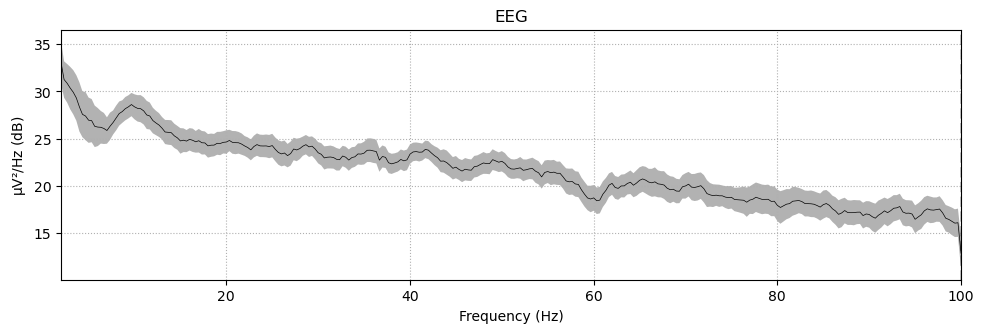

In [9]:
pp = 0
task = 'aln'
cond = 'rightmoves'
data, ppdir = load_epochs(pp, root_dir = root, erp_path = erps, cond = cond, task = task)

data.compute_psd(fmin=2.0, fmax=100).plot(average=True, picks="data", exclude="bads")
#data.compute_psd().plot_topomap(ch_type="eeg", normalize=False, contours=0)

In [7]:
arraydat = data.get_data()
arraydat.shape

(12, 65, 600)

In [ ]:
freqs = np.logspace(*np.log10([6, 35]), num=50)
freqs

In [8]:
freqs = np.logspace(*np.log10([6, 35]), num=50) #num here is how many frequencies you will have
n_cycles = 6 #freqs / 2.0  # different number of cycle per frequency #this is for morlet wavelet
channels = ['FCz', 'F3', 'Fz', 'F4', 'C3', 'Cz', 'C4', 'P3', 'Pz', 'P4']
#channels = ['C4']
ab = mne.time_frequency.tfr_morlet(
    data,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=False,
    decim=1,
    n_jobs=None,
    output = 'power'
)
ab

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    3.3s finished


(<AverageTFR | time : [-1.500000, 1.495000], freq : [6.000000, 35.000000], nave : 12, channels : 64, ~14.7 MB>,
 <AverageTFR | time : [-1.500000, 1.495000], freq : [6.000000, 35.000000], nave : 12, channels : 64, ~14.7 MB>)

In [6]:
freqs = np.logspace(*np.log10([6, 35]), num=40) #num here is how many frequencies you will have
n_cycles = 6 #freqs / 2.0  # different number of cycle per frequency #this is for morlet wavelet
channels = ['FCz', 'F3', 'Fz', 'F4', 'C3', 'Cz', 'C4', 'P3', 'Pz', 'P4']
#channels = ['C4']
power, itc = mne.time_frequency.tfr_morlet(
    data,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=False,
    return_itc=True,
    decim=1,
    n_jobs=None,
    picks=channels
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [7]:
power

<AverageTFR | time : [-1.500000, 1.495000], freq : [6.000000, 35.000000], nave : 12, channels : 10, ~1.9 MB>

In [ ]:
#df = pd.DataFrame(ab)
#can save array
df_filename = os.path.join('F:/Documents/Science/MirRevAdaptEEG/data/', 'test')
np.save(df_filename, ab)


No baseline correction applied
No baseline correction applied


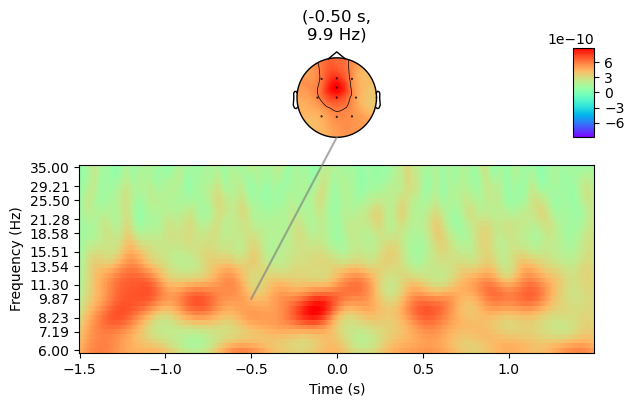

In [17]:
colormap = 'rainbow'
power.plot_joint(
    mode="mean", tmin=-1.5, tmax=1.5, timefreqs=[(-0.5, 10)], cmap = colormap
)

In [ ]:
#get grand averages - split according to conditions
root_directory = root
data_directory = os.path.join(root_directory, 'data/eeg/')

#read in evoked object
conditionnames = ['rightmoves', 'leftmoves']
tasknames = ['aln', 'rot', 'rdm', 'mir']

for task in range(0, len(tasknames)):
    for condition in range(0, len(conditionnames)):
        flist = []
        evoked_list = []
        for pp in participants:
            id_directory = os.path.join(data_directory, 'p%03d/' % participants[pp])
            pp_directory = os.path.join(id_directory, erps)
            fname = os.path.join(pp_directory, 'p%03d_%s_%s_rp-ave.fif' % (participants[pp], conditionnames[condition], tasknames[task]))
            if os.path.exists(fname) == False:
                continue
            evoked = mne.read_evokeds(fname)
            flist.append(evoked)
            evoked = evoked[0]
            evoked_list.append(evoked)
            if task == 0 and condition == 0:
                grand_aln_right = mne.grand_average(evoked_list)
                right_aln_flist = evoked_list
            elif task == 0 and condition == 1:
                grand_aln_left = mne.grand_average(evoked_list)
                left_aln_flist = evoked_list
            elif task == 1 and condition == 0:
                grand_rot_right = mne.grand_average(evoked_list)
                right_rot_flist = evoked_list
            elif task == 1 and condition == 1:
                grand_rot_left = mne.grand_average(evoked_list)
                left_rot_flist = evoked_list
            elif task == 2 and condition == 0:
                grand_rdm_right = mne.grand_average(evoked_list)
                right_rdm_flist = evoked_list
            elif task == 2 and condition == 1:
                grand_rdm_left = mne.grand_average(evoked_list)
                left_rdm_flist = evoked_list
            elif task == 3 and condition == 0:
                grand_mir_right = mne.grand_average(evoked_list)
                right_mir_flist = evoked_list
            elif task == 3 and condition == 1:
                grand_mir_left = mne.grand_average(evoked_list)
                left_mir_flist = evoked_list


In [ ]:
#runs for LRP ONLY: need separate files for C3 and C4

flists = ['aln_right', 'aln_left', 'rot_right', 'rot_left', 'rdm_right', 'rdm_left', 'mir_right', 'mir_left']
channels = ['C3', 'C4']
for channel in channels:
    for f in flists:
        newdf = pd.DataFrame()
        for pp in participants:
            if f == 'aln_right':
                for pp in range(0, len(right_aln_flist)):
                    df = right_aln_flist[pp].to_data_frame()
                    time = df['time'].tolist()
                    df = df[[channel]]
                    ppdat = []
                    for timept in range(0,300):
                        subdf = df.loc[timept,:].mean()
                        ppdat.append(subdf)
                    newdf['pp%03d'% pp] = ppdat
                newdf['time'] = time
                newdf_filename = os.path.join('F:/Documents/Science/MirRevAdaptEEG/data/', 'Evoked_DF_%s_%s_%s.csv' % (f, erps, channel))
                newdf.to_csv(newdf_filename)
            elif f == 'aln_left':
                for pp in range(0, len(left_aln_flist)):
                    df = left_aln_flist[pp].to_data_frame()
                    time = df['time'].tolist()
                    df = df[[channel]]
                    ppdat = []
                    for timept in range(0,300):
                        subdf = df.loc[timept,:].mean()
                        ppdat.append(subdf)
                    newdf['pp%03d'% pp] = ppdat
                newdf['time'] = time
                newdf_filename = os.path.join('F:/Documents/Science/MirRevAdaptEEG/data/', 'Evoked_DF_%s_%s_%s.csv' % (f, erps, channel))
                newdf.to_csv(newdf_filename)
            elif f == 'rot_right':
                for pp in range(0, len(right_rot_flist)):
                    df = right_rot_flist[pp].to_data_frame()
                    time = df['time'].tolist()
                    df = df[[channel]]
                    ppdat = []
                    for timept in range(0,300):
                        subdf = df.loc[timept,:].mean()
                        ppdat.append(subdf)
                    newdf['pp%03d'% pp] = ppdat
                newdf['time'] = time
                newdf_filename = os.path.join('F:/Documents/Science/MirRevAdaptEEG/data/', 'Evoked_DF_%s_%s_%s.csv' % (f, erps, channel))
                newdf.to_csv(newdf_filename)
            elif f == 'rot_left':
                for pp in range(0, len(left_rot_flist)):
                    df = left_rot_flist[pp].to_data_frame()
                    time = df['time'].tolist()
                    df = df[[channel]]
                    ppdat = []
                    for timept in range(0,300):
                        subdf = df.loc[timept,:].mean()
                        ppdat.append(subdf)
                    newdf['pp%03d'% pp] = ppdat
                newdf['time'] = time
                newdf_filename = os.path.join('F:/Documents/Science/MirRevAdaptEEG/data/', 'Evoked_DF_%s_%s_%s.csv' % (f, erps, channel))
                newdf.to_csv(newdf_filename)
            elif f == 'rdm_right':
                for pp in range(0, len(right_rdm_flist)):
                    df = right_rdm_flist[pp].to_data_frame()
                    time = df['time'].tolist()
                    df = df[[channel]]
                    ppdat = []
                    for timept in range(0,300):
                        subdf = df.loc[timept,:].mean()
                        ppdat.append(subdf)
                    newdf['pp%03d'% pp] = ppdat
                newdf['time'] = time
                newdf_filename = os.path.join('F:/Documents/Science/MirRevAdaptEEG/data/', 'Evoked_DF_%s_%s_%s.csv' % (f, erps, channel))
                newdf.to_csv(newdf_filename)
            elif f == 'rdm_left':
                for pp in range(0, len(left_rdm_flist)):
                    df = left_rdm_flist[pp].to_data_frame()
                    time = df['time'].tolist()
                    df = df[[channel]]
                    ppdat = []
                    for timept in range(0,300):
                        subdf = df.loc[timept,:].mean()
                        ppdat.append(subdf)
                    newdf['pp%03d'% pp] = ppdat
                newdf['time'] = time
                newdf_filename = os.path.join('F:/Documents/Science/MirRevAdaptEEG/data/', 'Evoked_DF_%s_%s_%s.csv' % (f, erps, channel))
                newdf.to_csv(newdf_filename)
            elif f == 'mir_right':
                for pp in range(0, len(right_mir_flist)):
                    df = right_mir_flist[pp].to_data_frame()
                    time = df['time'].tolist()
                    df = df[[channel]]
                    ppdat = []
                    for timept in range(0,300):
                        subdf = df.loc[timept,:].mean()
                        ppdat.append(subdf)
                    newdf['pp%03d'% pp] = ppdat
                newdf['time'] = time
                newdf_filename = os.path.join('F:/Documents/Science/MirRevAdaptEEG/data/', 'Evoked_DF_%s_%s_%s.csv' % (f, erps, channel))
                newdf.to_csv(newdf_filename)
            elif f == 'mir_left':
                for pp in range(0, len(left_mir_flist)):
                    df = left_mir_flist[pp].to_data_frame()
                    time = df['time'].tolist()
                    df = df[[channel]]
                    ppdat = []
                    for timept in range(0,300):
                        subdf = df.loc[timept,:].mean()
                        ppdat.append(subdf)
                    newdf['pp%03d'% pp] = ppdat
                newdf['time'] = time
                newdf_filename = os.path.join('F:/Documents/Science/MirRevAdaptEEG/data/', 'Evoked_DF_%s_%s_%s.csv' % (f, erps, channel))
                newdf.to_csv(newdf_filename)
             

In [ ]:
# Difference waves between aligned and perturbed conditions for C3
#channels = ['C3']
channels = ['C4']
# channels = ['Oz','O1','O2']
evokeds = dict(aln_right = right_aln_flist, 
               aln_left = left_aln_flist,
               rot_right = right_rot_flist,
               rot_left = left_rot_flist,
               rdm_right = right_rdm_flist,
               rdm_left = left_rdm_flist,
               mir_right = right_mir_flist,
               mir_left = left_mir_flist)
#plot
mne.viz.plot_compare_evokeds(evokeds, picks=channels, combine = 'mean', legend = 'lower right', ylim=dict(eeg=[-15, 5]), ci=True)